# ACA-Py & ACC-Py Basic Template

## Copy this template into the root folder of your notebook workspace to get started

### Imports

In [1]:
from aries_cloudcontroller import AriesAgentController
import os
from termcolor import colored

### Initialise the Agent Controller

In [2]:
api_key = os.getenv("ACAPY_ADMIN_API_KEY")
admin_url = os.getenv("ADMIN_URL")

print(
    f"Initialising a controller with admin api at {admin_url} and an api key of {api_key}"
)
agent_controller = AriesAgentController(admin_url, api_key)

Initialising a controller with admin api at http://bob-agent:3021 and an api key of adminApiKey


### Start a Webhook Server

In [3]:
webhook_port = os.getenv("WEBHOOK_PORT")
webhook_host = "0.0.0.0"

agent_controller.init_webhook_server(webhook_host, webhook_port)
await agent_controller.listen_webhooks()

print(f"Listening for webhooks from agent at http://{webhook_host}:{webhook_port}")

Listening for webhooks from agent at http://0.0.0.0:3010


## Register Agent Event Listeners

You can see some examples within the webhook_listeners recipe. Copy any relevant cells across and customise as needed.

In [8]:
listeners = []

# Receive connection messages
def connections_handler(payload):
    state = payload["state"]
    connection_id = payload["connection_id"]
    their_role = payload["their_role"]
    routing_state = payload["routing_state"]

    print("----------------------------------------------------------")
    print("Connection Webhook Event Received")
    print("Connection ID : ", connection_id)
    print("State : ", state)
    print("Routing State : ", routing_state)
    print("Their Role : ", their_role)
    print("----------------------------------------------------------")

    if state == "invitation":
        # Your business logic
        print("invitation")
    elif state == "request":
        # Your business logic
        print("request")

    elif state == "response":
        # Your business logic
        print("response")
    elif state == "active":
        # Your business logic
        print(
            colored(
                "Connection ID: {0} is now active.".format(connection_id),
                "green",
                attrs=["bold"],
            )
        )


connection_listener = {"handler": connections_handler, "topic": "connections"}

listeners.append(connection_listener)

agent_controller.register_listeners(listeners)

Subscribing too: connections


## Create Invitation

Note the current arguments specified are in their default configurations. 

In [12]:
# Alias for invited connection
alias = None
auto_accept = False
# Use public DID?
public = "false"
# Should this invitation be usable by multiple invitees?
multi_use = "false"

invitation_response = await agent_controller.connections.create_invitation(
    alias, auto_accept, public, multi_use
)
# Is equivalent to above. Arguments are optionally
# invitation_response = await agent_controller.connections.create_invitation()


# You probably want to keep this somewhere so you can enage in other protocols with this connection.
connection_id = invitation_response["connection_id"]

----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  b85c8880-e5ac-4219-9838-2ef64491af4d
State :  invitation
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
invitation


## Share Invitation Object with External Agent

Typically in this jupyter notebook playground that involves copying it across to another agent's business logic notebook where they are the invitee. (see invitee_template recipe)

In [13]:
invitation = invitation_response["invitation"]
## Copy this output
print(invitation)

{'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/connections/1.0/invitation', '@id': '8770a9f4-d38f-4c14-b9e8-a3d4f7aea9e0', 'serviceEndpoint': 'https://d3df60a216ea.ngrok.io', 'label': 'Bob', 'recipientKeys': ['9dbE6UbNjYyDW3XXhVTmufWH5FF9TVmWwChh9tc7xi7T']}


## Display Invite as QR Code

This is useful if you wish to establish a connection with a mobile wallet.

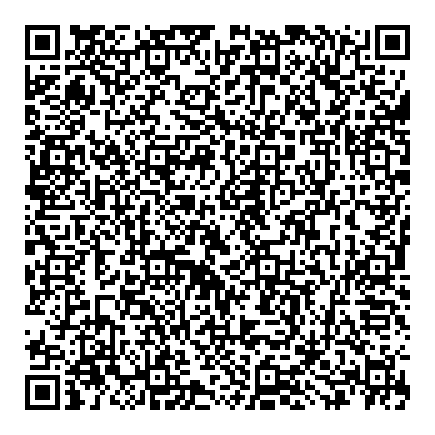

In [15]:
import qrcode

# Link for connection invitation
invitation_url = invitation_response["invitation_url"]
# Creating an instance of qrcode
qr = qrcode.QRCode(version=1, box_size=5, border=5)
qr.add_data(invitation_url)
qr.make(fit=True)
img = qr.make_image(fill="black", back_color="white")
img

## Accept Invitation Response

Note: You may not need to run this cell. It depends if this agent has the ACAPY_AUTO_ACCEPT_REQUESTS=true flag set.

In [ ]:
# Endpoint you expect to recieve messages at
my_endpoint = None
accept_request_response = await agent_controller.connections.accept_request(
    connection_id, my_endpoint
)

## Send Trust Ping

Once connection moves to response state one agent, either inviter or invitee needs to send a trust ping.

Note: you may not need to run this cell. It depends one of the agents has the ACAPY_AUTO_PING_CONNECTION=true flag set.

In [ ]:
comment = "Some Optional Comment"
message = await agent_controller.messaging.trust_ping(connection_id, comment)

## Your Own Business Logic

Now you should have an established, active connection you can write any custom logic you want to engage with protocols with the connection

In [ ]:
## Custom Logic

## Terminate Controller

Whenever you have finished with this notebook, be sure to terminate the controller. This is especially important if your business logic runs across multiple notebooks.

In [16]:
await agent_controller.terminate()